In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
from IPython.display import Image

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_csv = pd.read_csv('/content/drive/My Drive/ShipImages/Root/train.csv')
print('Data shape: ', data_csv.shape)
categories = {0: 'Cargo', 1:'Military', 2:'Carrier', 3:'Cruise', 4:'Tankers'}
data_csv['category'] = data_csv['category'] - 1
data_csv['label'] = data_csv['category'].map(categories)
data_csv['label']  = pd.Categorical(data_csv['label'])
data_csv.head(5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Counts of Observations')

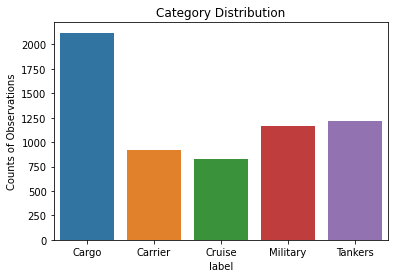

In [ ]:
sns.countplot(data_csv['label'])
plt.title('Category Distribution')
plt.xlabel('label')
plt.ylabel('Counts of Observations')

In [ ]:
import cv2

path = '/content/drive/My Drive/ShipImages/Root/images'

# List of image names
img_list = list(data_csv['image'])

data_img = []

for each in img_list:
    # Each image path
    each_path = os.path.join(path, each)
    # Read each image
    each_img = cv2.imread(each_path)
    # OpenCv default color is BGR. Convert it to RGB
    each_img= cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB)
    # Resize  the images
    each_img_resized = cv2.resize(each_img, (150,150))
    # Save arrays to a list
    data_img.append(each_img_resized)

# Converting list to numpy array
X = np.array(data_img)
print('Shape of X: ', X.shape)

Shape of X:  (6252, 150, 150, 3)


In [ ]:
from sklearn.preprocessing import OneHotEncoder
y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(data_csv['category'].values.reshape(-1,1))
print('Shape of y: ', y.shape)

Shape of y:  (6252, 5)


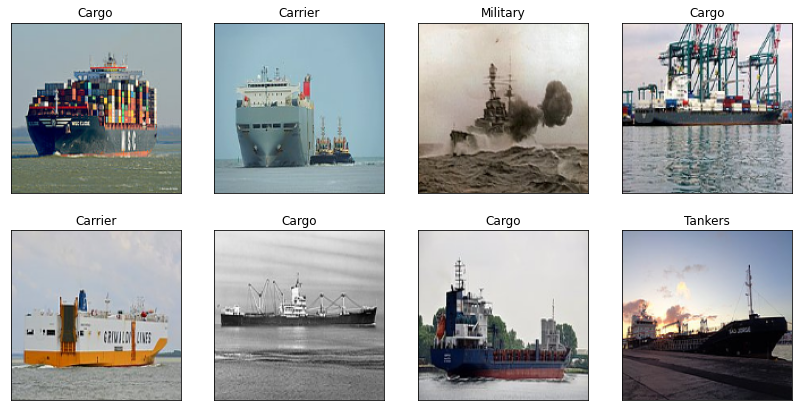

In [ ]:
indices = np.random.randint(0,6252,8) 
i = 1
plt.figure(figsize=(14,7))
for each in indices:
    plt.subplot(2,4,i)
    plt.imshow(X[each])
    plt.title(data_csv['label'].loc[each])
    plt.xticks([])
    plt.yticks([])
    i += 1

In [ ]:
from sklearn.model_selection import train_test_split

X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape:  (4251, 150, 150, 3)
y_train shape:  (4251, 5)
X_val shape  :  (1063, 150, 150, 3)
y_val shape  :  (1063, 5)
X_test shape :  (938, 150, 150, 3)
y_test shape :  (938, 5)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)

validation_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)
train_gen.fit(X_train)
validation_gen.fit(X_val)

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
from IPython.display import Image

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam

In [ ]:
Xception = Xception(weights = 'imagenet', include_top = False, input_shape=(150,150,3))
inception_v3 = InceptionV3(weights = 'imagenet', include_top = False, input_shape=(150,150,3))



83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
import os
import random
import itertools
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
#from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.vgg16 import preprocess_input as process_vgg16
from tensorflow.keras.applications.inception_v3 import preprocess_input as process_inception_v3
#from tensorflow.keras.applications.resnet50 import preprocess_input as process_resnet
from tensorflow.keras.applications.xception import preprocess_input as process_xception

import cv2

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#set_seed(33)

inp = Input((150,150,3))

Xception_process = Lambda(process_xception)(inp)
Xception = Xception(Xception_process)
x_Xception = GlobalMaxPool2D()(Xception)
x_Xception = Dense(128, activation='relu')(x_Xception)

inception_v3_process = Lambda(process_inception_v3)(inp)
inception_v3 = inception_v3(inception_v3_process)
x_inception_v3 = GlobalMaxPool2D()(inception_v3)
x_inception_v3 = Dense(128, activation='relu')(x_inception_v3)

x = Concatenate()([x_Xception, x_inception_v3])
out = Dense(5, activation='softmax')(x)

model = Model(inp, out)
model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=1e-4), metrics='accuracy')

es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=7)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


In [ ]:
batch_size = 32
epochs = 30

In [ ]:
history=model.fit(train_gen.flow(X_train, y_train, batch_size=batch_size), epochs = epochs, validation_data = validation_gen.flow(X_val, y_val, batch_size=batch_size), steps_per_epoch = X_train.shape[0] // batch_size)

Epoch 1/30
132/132 [==============================] - 134s 1s/step - loss: 0.1847 - accuracy: 0.9313 - val_loss: 0.4387 - val_accuracy: 0.8485
Epoch 2/30
132/132 [==============================] - 134s 1s/step - loss: 0.1726 - accuracy: 0.9358 - val_loss: 0.3930 - val_accuracy: 0.8664
Epoch 3/30
132/132 [==============================] - 134s 1s/step - loss: 0.1693 - accuracy: 0.9362 - val_loss: 0.4106 - val_accuracy: 0.8711
Epoch 4/30
132/132 [==============================] - 134s 1s/step - loss: 0.1800 - accuracy: 0.9374 - val_loss: 0.3345 - val_accuracy: 0.8890
Epoch 5/30
132/132 [==============================] - 134s 1s/step - loss: 0.1676 - accuracy: 0.9377 - val_loss: 0.3631 - val_accuracy: 0.8739
Epoch 6/30
132/132 [==============================] - 134s 1s/step - loss: 0.1619 - accuracy: 0.9412 - val_loss: 0.3872 - val_accuracy: 0.8815
Epoch 7/30
132/132 [==============================] - 134s 1s/step - loss: 0.1656 - accuracy: 0.9391 - val_loss: 0.3930 - val_accuracy: 0.8692

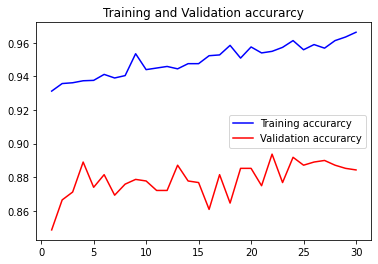

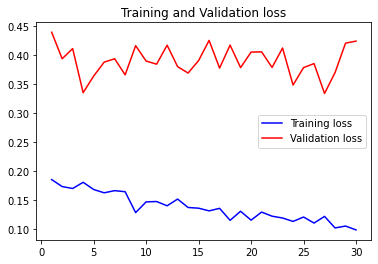

In [ ]:
#lets now plot the train and val curve
import matplotlib.pyplot as plt
#get the details form the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

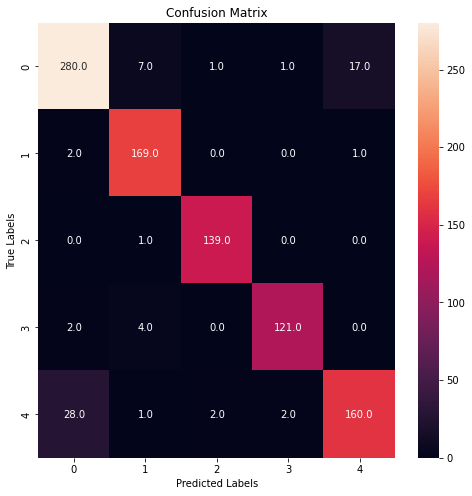

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicting labels from X_test data
y_pred = model.predict(X_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)

# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       306
           1       0.93      0.98      0.95       172
           2       0.98      0.99      0.99       140
           3       0.98      0.95      0.96       127
           4       0.90      0.83      0.86       193

    accuracy                           0.93       938
   macro avg       0.94      0.93      0.93       938
weighted avg       0.93      0.93      0.93       938



In [ ]:
model.save('ensembling_30.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
